# Python Script for importing data into SQL

In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Savita@1977',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/KIIT/Desktop/Placement/Ecommerce project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",username="root",password="Savita@1977",database="ecommerce")

cur=db.cursor()



# Basic Questions

# 1. List all unique cities where customers are located. 


In [66]:
query= """ select distinct customer_city as City_Name from customers """
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [9]:
query=""" select count(order_id) as `Total orders of 2017` from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)

data=cur.fetchall()

"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

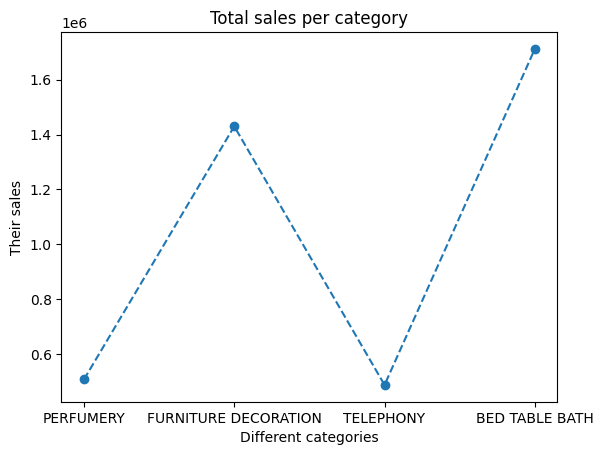

In [41]:
query=""" select upper(products.product_category) as category,ceil(sum(payments.payment_value)) as sales from products join
order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id group by category """

cur.execute(query)

data=cur.fetchall()

#visualisation
df=pd.DataFrame(data,columns=["Category","Sales"])
df2=df.head(4)
#Since the categories are too many i would like to visualize few of them 
df2
plt.plot(df2["Category"],df2["Sales"],ls="--",marker="o")
plt.title("Total sales per category")
plt.xlabel("Different categories")
plt.ylabel("Their sales")
plt.show()

# 4. Calculate the percentage of orders that were paid in installments.


In [47]:
query=""" select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments """

cur.execute(query)

data=cur.fetchall()
"The percentage of orders that were paid in installments is",data

('The percentage of orders that were paid in installments is',
 [(Decimal('99.9981'),)])

# 5. Count the number of customers from each state. 

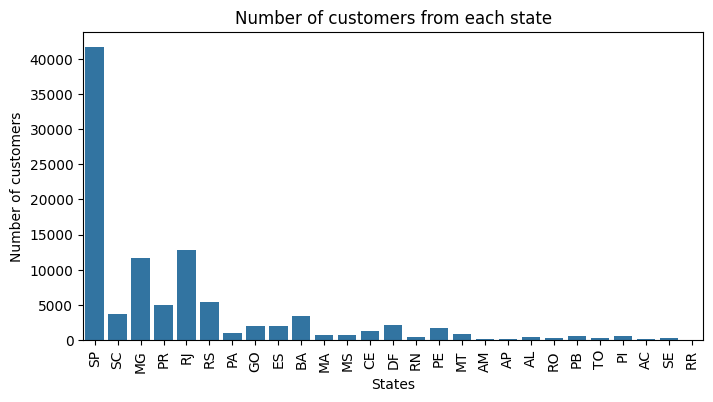

In [65]:
query=""" select customer_state state,count(customer_id) from customers group by customer_state"""

cur.execute(query)

data=cur.fetchall()

#visualisation 
df=pd.DataFrame(data,columns=["States","Number"])
plt.figure(figsize=(8,4))
sns.barplot(data=df,x=df["States"],y=df["Number"])
plt.title("Number of customers from each state")
plt.ylabel("Number of customers")
plt.xticks(rotation=90)
plt.show()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.


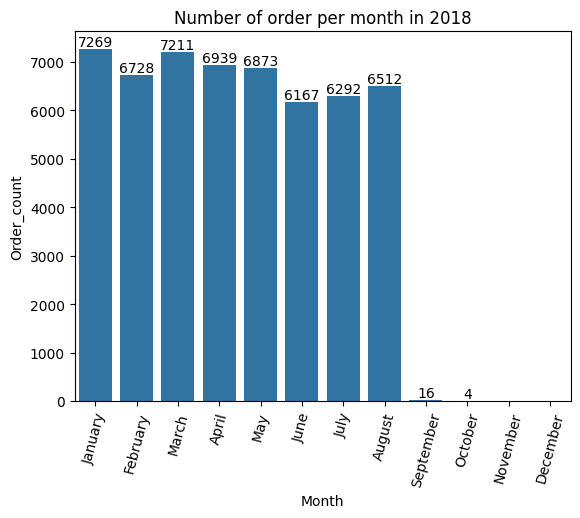

In [86]:
query=""" select monthname(order_purchase_timestamp) as `Month name`,
count(order_id) Number_orders from orders where year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp)  """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month","Order_count"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.xticks(rotation=75)
ax=sns.barplot(data=df,x=df["Month"],y=df["Order_count"], order=o)
ax.bar_label(ax.containers[0])
plt.title("Number of order per month in 2018")
plt.show()


# 2. Find the average number of products per order, grouped by customer city.


In [91]:
query=""" with order_details as 
(select orders.order_id,orders.customer_id,count(order_items.order_item_id) as oc 
from orders join order_items on orders.order_id=order_items.order_id group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(order_details.oc),2) av from customers join order_details
 on customers.customer_id=order_details.customer_id group by customers.customer_city order by av desc   """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer city","Number of products per order"])
df.head(10)

,Customer city,Number of products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 3. Calculate the percentage of total revenue contributed by each product category.


In [97]:
query="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2)
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Product Category","Percentage of contribution"])
df.head()

,Product Category,Percentage of contribution
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32


# 4. Identify the correlation between product price and the number of times a product has been purchased.


In [102]:
query=""" select products.product_category,count(order_items.product_id),avg(order_items.price) from products join order_items on
order_items.product_id=products.product_id
group by products.product_category  """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","Order_count","Price"])
print(np.corrcoef(df["Price"],df["Order_count"]))
#It means there is no impact of price on order_count and vice verse they are not correlated
#Hence we say that there neutral relation between Category and Order_count

[[ 1.         -0.10631552]
 [-0.10631552  1.        ]]


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.


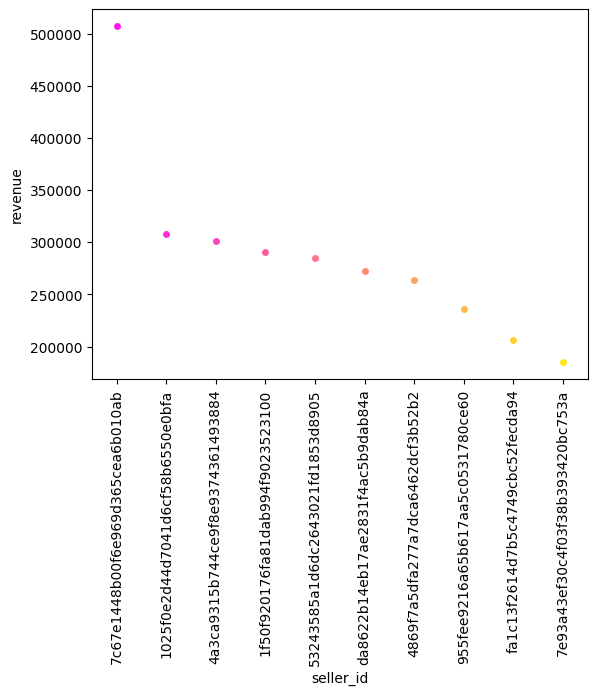

In [115]:
query=""" select *,dense_rank() over(order by pv desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) pv
from order_items join payments on order_items.order_id=payments.order_id group by order_items.seller_id) as a """

cur.execute(query)

data=cur.fetchall()
#data visualisation
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df2=df.head(10)
df2
plt.xticks(rotation=90)
sns.stripplot(data=df2,x="seller_id",y="revenue",hue="seller_id",palette="spring",)
plt.show()

# Advanced Questions

# 1.Calculate the moving average of order values for each customer over their order history.

In [117]:
query=""" select customer_id,order_purchase_timestamp,p,avg(p) over (partition by customer_id 
order by order_purchase_timestamp rows between 2  preceding and current row) as mov_avg from 
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value p from payments join orders on 
orders.order_id=payments.order_id) as a """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_time","payment","mov_avg"])
df.head()
 

,customer_id,order_purchase_time,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 2. Calculate the cumulative sales per month for each year.


In [120]:
query="""  select years,months,payments,sum(payments) over (order by years,months)  as cummulative_sales from 
 (select year(orders.order_purchase_timestamp) years,month(orders.order_purchase_timestamp) months,
 round(sum(payments.payment_value),2) payments from orders join payments on
 orders.order_id=payments.order_id group by years,months order by years asc,months asc) as a """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Year","Month","Sales","Cummulative_Sales"])
df.head()

,Year,Month,Sales,Cummulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# 3. Calculate the year-over-year growth rate of total sales.


In [128]:
query=""" with a as (select year(order_purchase_timestamp) as years,round(sum(payments.payment_value),2) as va from payments join orders on 
orders.order_id=payments.order_id group by years order by years)

select years,((va-lag(va,1)  over (order by years))/lag(va,1)  over (order by years))*100 as previous_year from a """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Year","YOY%_Growth"])
df

,Year,YOY%_Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [130]:
query=""" with a as (select customers.customer_id ,min(orders.order_purchase_timestamp) as first_order from orders join customers on 
customers.customer_id=orders.customer_id group by customers.customer_id ),
b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order from a join orders 
on a.customer_id=orders.customer_id and orders.order_purchase_timestamp > a.first_order and  orders.order_purchase_timestamp < date_add(a.first_order,
interval 6 month) group by a.customer_id)
select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from a left join b on a.customer_id=b.customer_id """

cur.execute(query)

data=cur.fetchall()

data
#here we dont have any data because none of the customers purchased again within the 6 months

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

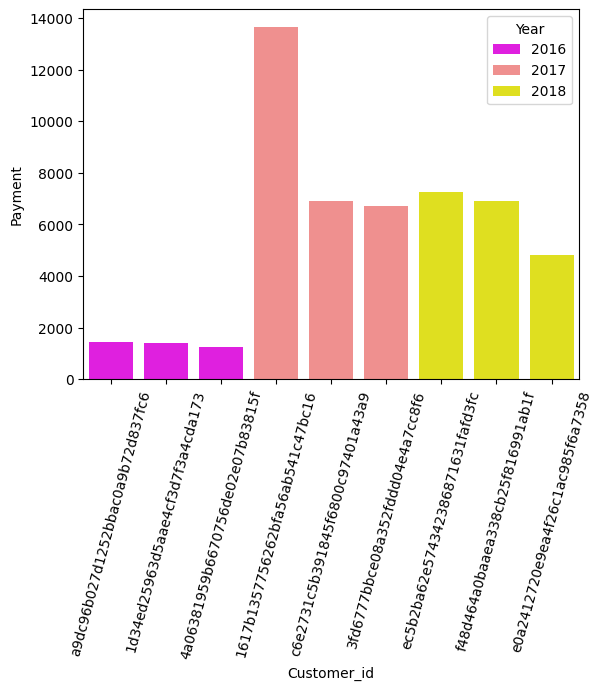

In [141]:
query="""select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders. customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Year","Customer_id","Payment","Rank"])
sns.barplot(data=df,x=df["Customer_id"],y=df["Payment"],hue=df["Year"],palette="spring")
plt.xticks(rotation=75)
plt.show()